In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import noisereduce as nr
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import jiwer  
import time

import pywt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

c:\Users\gabry\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

## Loading Data

In [2]:
# Konfigurasi
DATASET_PATH = "augdata"
COMMANDS = ["baca", "berhenti", "foto", "halo", "info", "kembali", "ulang"]

In [3]:
# Load data
X = []
y = []

for label in COMMANDS:
    folder_path = os.path.join(DATASET_PATH, label)
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder_path, filename)
            X.append(file_path)
            y.append(label)

X = np.array(X)  
y = np.array(y)

In [4]:
len(X)

17787

In [5]:
# Buat dataframe
df = pd.DataFrame()
df['speech'] = X 
df['label'] = y

df.head()

,speech,label
0,augdata\baca\baca100_dyn.wav,baca
1,augdata\baca\baca100_noise.wav,baca
2,augdata\baca\baca100_original.wav,baca
3,augdata\baca\baca100_pitch.wav,baca
4,augdata\baca\baca100_shift.wav,baca


In [6]:

df['label'].value_counts()

label
kembali     2576
foto        2548
baca        2541
berhenti    2541
ulang       2541
info        2527
halo        2513
Name: count, dtype: int64

In [7]:
# Tahapan Preprocessing

def load_audio(file_path, sr=16000):
    audio, sample_rate = librosa.load(file_path, sr=sr)
    return audio / np.max(np.abs(audio)), sample_rate 

In [8]:
# Dapatkan jumlah core
num_cores = multiprocessing.cpu_count()

# Copy DataFrame
dfn = df.copy()

# Jalankan preprocessing
results = Parallel(n_jobs=num_cores)(
    delayed(load_audio)(file_path)
    for file_path in dfn['speech']
)

dfn.head()


,speech,label
0,augdata\baca\baca100_dyn.wav,baca
1,augdata\baca\baca100_noise.wav,baca
2,augdata\baca\baca100_original.wav,baca
3,augdata\baca\baca100_pitch.wav,baca
4,augdata\baca\baca100_shift.wav,baca


## EDA

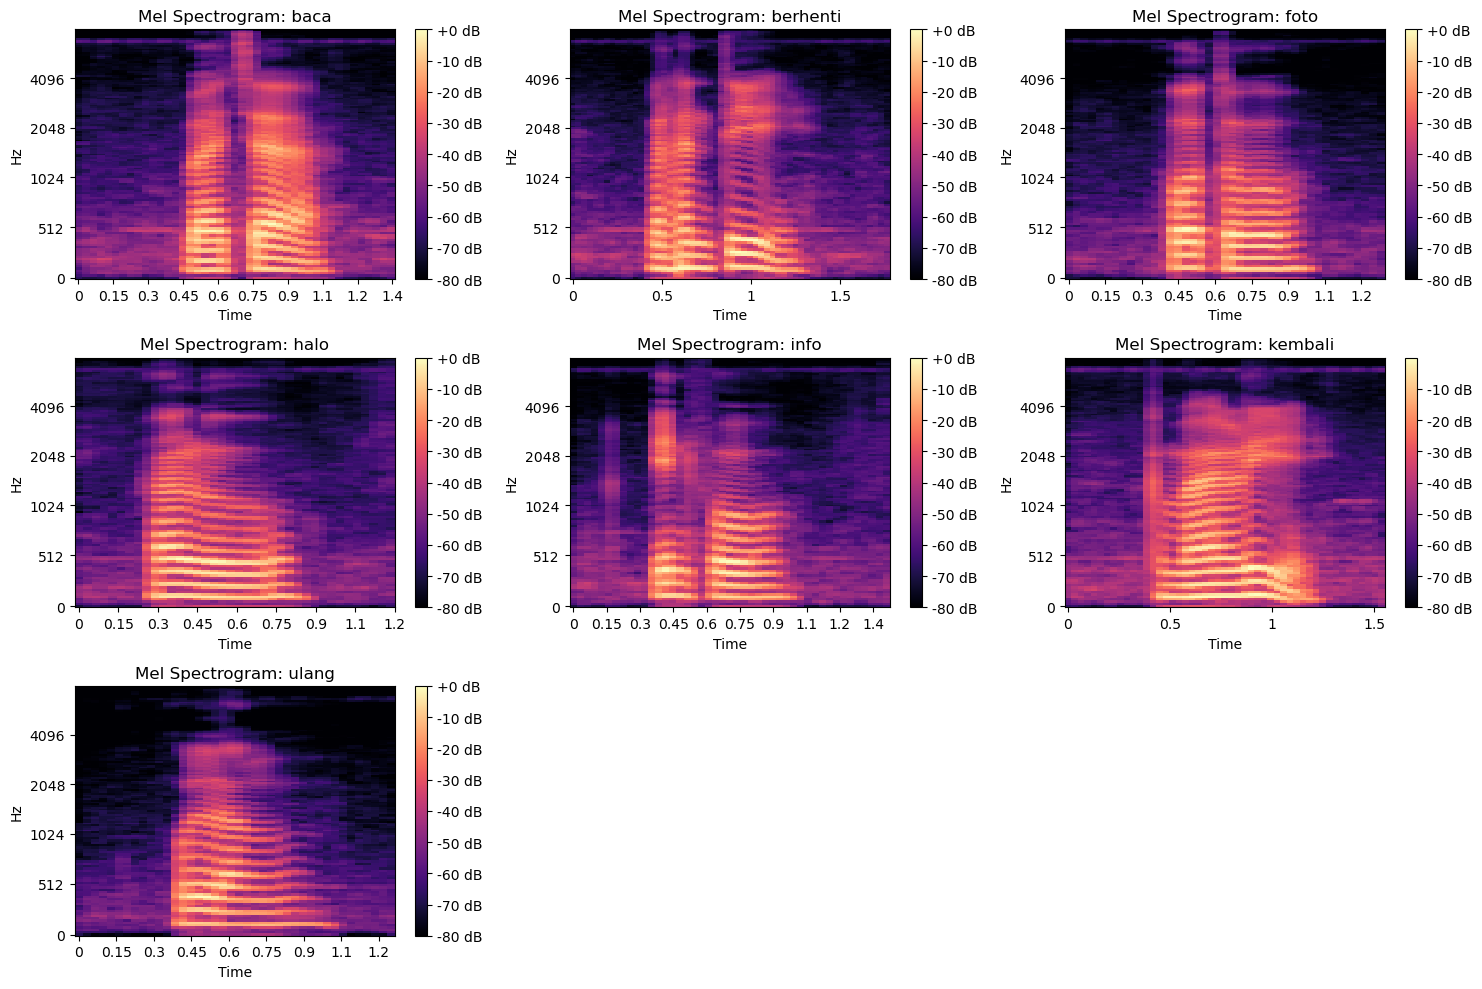

In [9]:
# Visualisasi spectrogram per label
def visualize_per_label(dfn):
    labels = dfn['label'].unique()

    plt.figure(figsize=(15, 10))

    for i, label in enumerate(labels):
        example_path = dfn[dfn['label'] == label]['speech'].values[0]

        # Preprocessing
        audio, sr = load_audio(example_path)

        # Menghitung Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)

        # Plot
        plt.subplot(3, 3, i + 1)
        librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                                 sr=sr, x_axis='time', y_axis='mel')
        plt.title(f'Mel Spectrogram: {label}')
        plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
visualize_per_label(dfn)

## MFCC

In [10]:
# def extract_mfcc(audio, sample_rate, n_mfcc=13):
#     """Extract MFCC features from audio"""
#     mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
#     return mfcc.T  # shape: (time_steps, n_mfcc)

# def full_mfcc_pipeline(file_path):
#     """Full processing pipeline for a single audio file"""
#     audio, sr = load_audio(file_path)
#     return extract_mfcc(audio, sr)

# def parallel_mfcc_extraction(file_paths, n_jobs=-1):
#     return Parallel(n_jobs=n_jobs)(
#         delayed(full_mfcc_pipeline)(file_path)
#         for file_path in tqdm(file_paths, desc="Extracting MFCC features")
#     )

# # Usage
# dfn['mfcc'] = parallel_mfcc_extraction(dfn['speech'].values)
# dfn.head()


# Parameter
SAMPLE_RATE = 16000
N_MFCC = 13
N_MELS = 22
WINDOW = int(SAMPLE_RATE * 0.01)
HOP = int(SAMPLE_RATE * 0.005)

# Load dan proses WPD
def load_audio(fp): return librosa.load(fp, sr=SAMPLE_RATE)[0]
def wpd(signal): 
    wp = pywt.WaveletPacket(signal, wavelet='db4', mode='symmetric', maxlevel=3)
    return np.concatenate([n.data for n in wp.get_level(3, 'freq')])

# Ekstrak MFCC dari sinyal hasil WPD
def extract_mfcc(signal): 
    return librosa.feature.mfcc(y=wpd(signal), sr=SAMPLE_RATE, n_mfcc=N_MFCC, 
                                n_mels=N_MELS, n_fft=WINDOW, hop_length=HOP).T

# Proses paralel
def process_all(paths): 
    return Parallel(n_jobs=-1)(delayed(lambda p: extract_mfcc(load_audio(p)))(p) 
                               for p in tqdm(paths, desc="Extracting MFCC"))

# Pemakaian
dfn['mfcc'] = process_all(dfn['speech'].values)

Extracting MFCC: 100%|██████████| 17787/17787 [00:11<00:00, 1548.37it/s]


In [11]:
# # Konversi MFCC menjadi array 3D: (samples, timesteps, n_mfcc)
# X_mfcc = pad_sequences(dfn['mfcc'], padding='post', dtype='float32')  


le = LabelEncoder()
dfn['label_encoded']= le.fit_transform(dfn['label'])

# Print the encoding assignment
for label, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"'{label}' -> {encoded}")


'baca' -> 0
'berhenti' -> 1
'foto' -> 2
'halo' -> 3
'info' -> 4
'kembali' -> 5
'ulang' -> 6


# Modeling

In [12]:
# 2. Pisahkan original dan augmentasi
df_original = dfn[dfn['speech'].str.endswith('_original.wav')]
df_augmented = dfn[~dfn['speech'].str.endswith('_original.wav')]

# 3. Split original: 55% training, 45% validation
df_train_orig, df_val = train_test_split(
    df_original,
    test_size=0.45,
    stratify=df_original['label_encoded'],
    random_state=42
)

In [13]:
df_val.head()

,speech,label,mfcc,label_encoded
15647,augdata\ulang\ulang152_original.wav,ulang,"[[-310.09085, 39.57232, 5.7471943, 15.312489, ...",6
10887,augdata\info\info197_original.wav,info,"[[-310.16687, 17.359652, 12.862658, 1.6317227,...",4
3544,augdata\berhenti\berhenti22_original.wav,berhenti,"[[-192.86526, 31.22875, -27.194561, -8.607968,...",1
11650,augdata\info\info295_original.wav,info,"[[-411.98166, 0.0, 9.107739e-06, 0.0, 8.828675...",4
10341,augdata\info\info126_original.wav,info,"[[-280.74707, 2.3549583, -27.107258, -18.37631...",4


In [14]:
df_original['label'].value_counts()

label
kembali     368
foto        364
baca        363
berhenti    363
ulang       363
info        361
halo        359
Name: count, dtype: int64

In [15]:
# 4. Gabungkan train original dan augmentasi
df_train = pd.concat([df_train_orig, df_augmented], ignore_index=True)

# Temukan panjang maksimum di seluruh data (train + val) agar padding seragam
all_mfcc = df_train['mfcc'].tolist() + df_val['mfcc'].tolist()
max_timesteps = max([len(m) for m in all_mfcc])

# Lakukan padding dengan panjang waktu tetap
X_train = pad_sequences(df_train['mfcc'], padding='post', dtype='float32', maxlen=max_timesteps)
X_val = pad_sequences(df_val['mfcc'], padding='post', dtype='float32', maxlen=max_timesteps)


In [16]:
df_train['label'].value_counts()

label
kembali     2410
foto        2384
baca        2378
ulang       2378
berhenti    2378
info        2364
halo        2351
Name: count, dtype: int64

In [17]:
df_val['label'].value_counts()

label
kembali     166
foto        164
ulang       163
info        163
berhenti    163
baca        163
halo        162
Name: count, dtype: int64

In [18]:
# 6. Label (encoded & one-hot)
y_train = df_train['label_encoded'].to_numpy()
y_val = df_val['label_encoded'].to_numpy()

num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

In [19]:
# # Split Data
# X_train, X_val, y_train, y_val = train_test_split(
#     X_mfcc, y_encoded, test_size=0.1, stratify=y_encoded, random_state=42
#     )

In [20]:
# # One-hot encoding 
# num_classes = len(np.unique(y_encoded))
# y_train_cat = to_categorical(y_train, num_classes)
# y_val_cat = to_categorical(y_val, num_classes)

In [21]:
# Modeling

model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 930, 13)           0         
                                                                 
 lstm (LSTM)                 (None, 930, 128)          72704     
                                                                 
 lstm_1 (LSTM)               (None, 930, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [22]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [23]:
# Training
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

# val_accuracy terbaik
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  
print(f"Val accuracy terbaik: {best_val_acc:.4f} pada epoch ke-{best_epoch}")

Epoch 1/100
521/521 [==============================] - 109s 185ms/step - loss: 1.6661 - accuracy: 0.2979 - val_loss: 1.2439 - val_accuracy: 0.4598
Epoch 2/100
521/521 [==============================] - 94s 181ms/step - loss: 1.1481 - accuracy: 0.5459 - val_loss: 0.8076 - val_accuracy: 0.6670
Epoch 3/100
521/521 [==============================] - 103s 197ms/step - loss: 0.9079 - accuracy: 0.6592 - val_loss: 0.5335 - val_accuracy: 0.8191
Epoch 4/100
521/521 [==============================] - 106s 204ms/step - loss: 0.7241 - accuracy: 0.7381 - val_loss: 0.2906 - val_accuracy: 0.9065
Epoch 5/100
521/521 [==============================] - 109s 210ms/step - loss: 0.5722 - accuracy: 0.7999 - val_loss: 0.2381 - val_accuracy: 0.9213
Epoch 6/100
521/521 [==============================] - 109s 209ms/step - loss: 0.4412 - accuracy: 0.8490 - val_loss: 0.1220 - val_accuracy: 0.9624
Epoch 7/100
521/521 [==============================] - 110s 212ms/step - loss: 0.3384 - accuracy: 0.8882 - val_loss: 0.

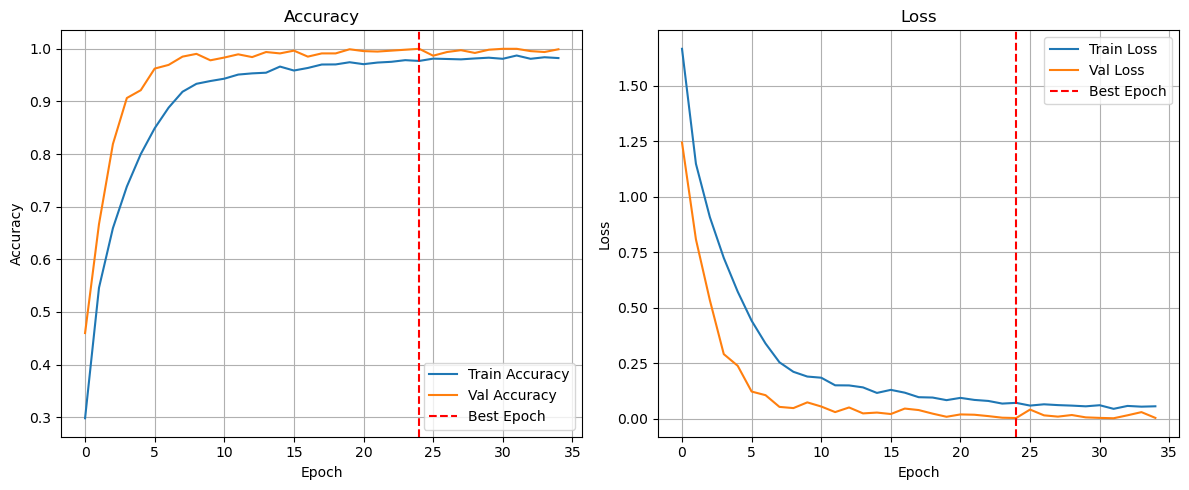

In [24]:
# Grafik akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Grafik loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [25]:
# Evaluasi

# Predict
start = time.time()
y_pred_probs = model.predict(X_val)
end = time.time()

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

# WER
ref = [le.classes_[i] for i in y_true]
hyp = [le.classes_[i] for i in y_pred]
wer = jiwer.wer(ref, hyp)

# RTF
audio_duration_total = (X_val.shape[0] * X_val.shape[1]) / 16000  # asumsi 16kHz
rtf = (end - start) / audio_duration_total

# Precision, Recall, F1 Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Classification report
report = classification_report(y_true, y_pred, target_names=le.classes_)
print("=== Classification Report ===")
print(report)
print(f"Word Error Rate (WER): {wer:.4f}")
print(f"Real Time Factor (RTF): {rtf:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

36/36 [==============================] - 7s 94ms/step
=== Classification Report ===
              precision    recall  f1-score   support

        baca       1.00      1.00      1.00       163
    berhenti       1.00      1.00      1.00       163
        foto       1.00      1.00      1.00       164
        halo       1.00      1.00      1.00       162
        info       1.00      1.00      1.00       163
     kembali       1.00      1.00      1.00       166
       ulang       1.00      1.00      1.00       163

    accuracy                           1.00      1144
   macro avg       1.00      1.00      1.00      1144
weighted avg       1.00      1.00      1.00      1144

Word Error Rate (WER): 0.0000
Real Time Factor (RTF): 0.1136
Precision (weighted): 1.0000
Recall (weighted): 1.0000
F1 Score (weighted): 1.0000
